<b>Final Project notebook of DSIP Course<b/><br/>
Question 4 - Classifier of fake and real pictures given as images Data<br/>
In the dirctory "TrainData"
Real images gets directory called "Real"
Fake images gets directory called "Fake"

In [133]:
# Important libraries to import
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import csv

<b>Part 1 - Properties extraction <b/>

Preparing the Data to the Classifier

In [2]:
# Part 1: Q1 Functions
def centered(real_images,fake_images):
    # This function centeres the arrays of the pictures - real & fake picturs
    # Given Arguments: The arrays with 500 pictures - real_images & fake_images
    # Return Values: Two centered arrays of FFT of all the pictures
    for i in range(len(real_images)):
        real_images[i] = np.fft.fftshift(real_images[i])
        fake_images[i] = np.fft.fftshift(fake_images[i])
    return [real_images,fake_images]

def azimuthalAverage(arr) :
    # This function calculates the azimuthal average of a given arr ()
    # Given arguments : arr - array which contains the centered DFT of picture
    # Return values : azimuth_avg - array that contains the azimuthal average for each radius
    r = np.zeros(arr.shape)
    rows_size = arr.shape[0];
    cols_size = arr.shape[1];
    
    ## initiallize array r that contains for each cell his radius from center
    for i in range(rows_size): # run all the rows
        for j in range(cols_size): # run all the cols
            r[i,j] = int(math.sqrt((rows_size/2-i)**2 + (cols_size/2 - j)**2))
            
    
    ## create array of arrays which contains the values for each radius
    azimuth_avg = np.zeros(int(np.max(r) + 1), dtype=object)
    
    for i in range(len(azimuth_avg)):
        azimuth_avg[i] = [];
    
    ## append to azimuth_avg[R] all the values that on the circle with radius R
    for i in range(rows_size):
        for j in range(cols_size):
            azimuth_avg[int(r[i,j])].append(int(arr[i,j]))
            
    ## Exchange each arr with radius R to his average     
    for i in range(len(azimuth_avg)):
        azimuth_avg[i] = np.average(azimuth_avg[i])
    
    return azimuth_avg;

In [3]:
# Q1,Q2.a  - Initiallize array of Objects (Images/Matrix)
real_images = np.zeros((500), dtype=object)
fake_images = np.zeros((500), dtype=object)

# Read the images 
for i in range(500) :
    real_images[i] = cv2.imread('TrainData\Real\\' + str(i) +'.jpg',0)
    fake_images[i] = cv2.imread('TrainData\Fake\\' + str(i) +'.jpg',0)

In [4]:
# NOT part of the submition -- Showing the an Image
cv2.imshow('image',fake_images[10]);
cv2.waitKey(0);
cv2.destroyAllWindows(); ## Closing all windows

In [5]:
# Q2.b - FFT 2 Dim for each image
for i in range(len(real_images)) :
    real_images[i] = np.fft.fft2(real_images[i])
    fake_images[i] = np.fft.fft2(fake_images[i])

In [6]:
# Q2.c - Center all the images FFT
for i in range(len(real_images)) :
    real_images[i] = np.fft.fftshift(real_images[i])
    fake_images[i] = np.fft.fftshift(fake_images[i])

In [7]:
# Q2.d - Add 10^-8 to the centered DFT 
real_images = real_images + 1e-8;
fake_images = fake_images + 1e-8;

In [8]:
# Q2.e - Claculate the magnitude in db of the centered DFT 
for i in range(len(real_images)) :
    real_images[i] = 20*np.log10(abs(real_images[i]))
    fake_images[i] = 20*np.log10(abs(fake_images[i]))

In [9]:
# Q2.f - Calculate the azimuthal average for each image
for i in range(len(real_images)) :
    real_images[i] = azimuthalAverage(real_images[i])
    fake_images[i] = azimuthalAverage(fake_images[i])

<h1>Part 2 - Train Logistic Regressor<h1/>

In [69]:
# Part 2 - Functions
def addOnesToMatrix(X):
    # This function adding a first culomn in the matrix X given
    # Given Arguments: X - original matrix
    # Return Value: X - The original matrix with first culomn of ones
    X_ones = np.ones((X.shape[0],X.shape[1]+1))
    X_ones[:,1:] = X
    return X_ones

def likelihoodFunc(z):
    # This function computes the Reasonability function (likelihood)
    # Given Arguments: z - the vector = w.T@x
    # Return Values: sigma - The likelihood function
    return 1 / (1 + np.exp(-z))

## Function For Q2
def gradientDescent(w,X,t,itter,alpha):
    direction = 0
    for m in range(itter):
        for n in range(X.shape[0]):
            ## direction is the function that determines to which direction to prove
            direction = direction + X[n,:]*(likelihoodFunc(w.T@X[n,:]) - t[n]) # direction.shape = (31,)
        w = w - alpha * direction
    return w

def confusionMatrix(X,y,w,th):
    # This function computes the confusion matrix of our Classifier
    # Given Arguments: X - the properties, y - the tags ('0' or '1'), w - coefficients vector, th - Thresold
    # Return Values: conf - Confusion matrix
    conf = np.zeros((2,2))
    for i in range(X.shape[0]):
        p = likelihoodFunc(w.T@X[i,:])
        if (p > th): ## if predict one
            conf[0,np.mod(int(y[i]+1),2)] += 1
        else: ## if predict zero
            conf[1,np.mod(int(y[i]+1),2)] += 1
    return conf

def shuffle(X,t):
    # This function shuffle the Data matrix and her Tags vector
    # Given Argument: X - the Data matrix, t - the tags vector
    # Return Value : tmp_X - the Data matrix after shuffle, tmp_t - the tags vector after shuffle
    tmp_X = np.zeros((X.shape[0],X.shape[1]));
    tmp_t = np.zeros(len(t));
    for i in range(0,len(t),2):
        tmp_X[i,:] = X[int(i/2),:]
        tmp_X[i + 1,:] = X[int(i/2) + 500,:]
        tmp_t[i] = t[int(i/2)]
        tmp_t[i + 1] = t[int(i/2) + 500]
    return [tmp_X,tmp_t]
        
def mse(X,w,t):
    # This function computes the MSE - Mean Squered Error
    # Given Argument: X - the Data matrix we want to compute the error , w - Coefficients vector,
    # t - the tags of the Data
    # Return Value : mse - The error
    mse = 0
    for n in range(X.shape[0]):
        mse = mse + ((likelihoodFunc(w.T@X[n,:]) - t[n])**2)
    mse = mse / X.shape[0]
    return mse

def accuracy(conf_matrix):
    # This function computes the Accuracy of the Classifier (each confusion matrix represents a classifier)
    # Given Arguments: conf_matrix - confusion matrix of specific Data
    # Return Values: The accuracy of the Classifier
    TP = conf_matrix[0,0]
    TN = conf_matrix[1,1]
    return (TP + TN) / conf_matrix.sum()

def crossEntropy(X,y,w):
    # This function computes the Cross Entropy function
    # Given Arguments: X - the matrix of the Data (2 props to each object),
    # y - the tag of each picture
    # Return Values: The Cross Entropy value
    Lce = 0
    for n in range(len(y)):
        Lce = Lce - y[n]*np.log(likelihoodFunc(w.T@X[n,:]) + 1e-08) - (1-y[n])*(np.log(1 - likelihoodFunc(w.T@X[n,:])
                                                                                                           + 1e-08))
    return Lce

def ratesTPAndFP(conf_matrix):
    # This function computes the True Positive and False Positive rates according to given matrix
    # Given Arguments: conf_matrix - confusion matrix of specific Data
    # Return Values: TP_rate - True Positive rate, FP_rate - Falsee Positive rate
    TP_rate = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
    FP_rate = conf_matrix[0,1] / (conf_matrix[0,1] + conf_matrix[1,1])
    return [TP_rate,FP_rate]

def ROC(X,t,w):
    # This function computes the rates TP,FP for each optional threshold
    # Given Arguments: X - Data of the patients, t - tag for each patient (0 or 1), w - the optimal coefficients
    # Return Values: TP_rates - True Positive rates, FP_rates - Falsee Positive rates
    th = np.arange(0.1,1,0.01)
    TP_rates = np.zeros(len(th))
    FP_rates = np.zeros(len(th))
    
    for i in range(len(th)):
        [TP_rates[i],FP_rates[i]] = ratesTPAndFP(confusionMatrix(X,t,w,th[i]))
    return [TP_rates,FP_rates]



In [70]:
# Q3 - Preparing the Data to the Classification - Specify the tag for each picture
Data = np.ones((1000,723)) ## Represents the properties of each picture
Tags = np.zeros(1000) ## Represents the tag for picture: y = 0 for real picture, y = 1 for fake picture

for i in range(len(real_images)):
    Data[i,1:] = real_images[i][1:723]
    Data[i + 500,1:] = fake_images[i][1:723]
    Tags[i + 500] = 1
    
# Divide the Train and Test series
[X,t] = shuffle(Data,Tags)
X_train = X[0:750,:]
t_train = t[0:750]
X_test = X[750:,:]
t_test = t[750:]

0


C:\Users\ofirn\AppData\Local\Temp/ipykernel_4792/1479359534.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\ofirn\AppData\Local\Temp/ipykernel_4792/1479359534.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


1


C:\Users\ofirn\AppData\Local\Temp/ipykernel_4792/1479359534.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\ofirn\AppData\Local\Temp/ipykernel_4792/1479359534.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


2


C:\Users\ofirn\AppData\Local\Temp/ipykernel_4792/1479359534.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\ofirn\AppData\Local\Temp/ipykernel_4792/1479359534.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


3


C:\Users\ofirn\AppData\Local\Temp/ipykernel_4792/1479359534.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\ofirn\AppData\Local\Temp/ipykernel_4792/1479359534.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


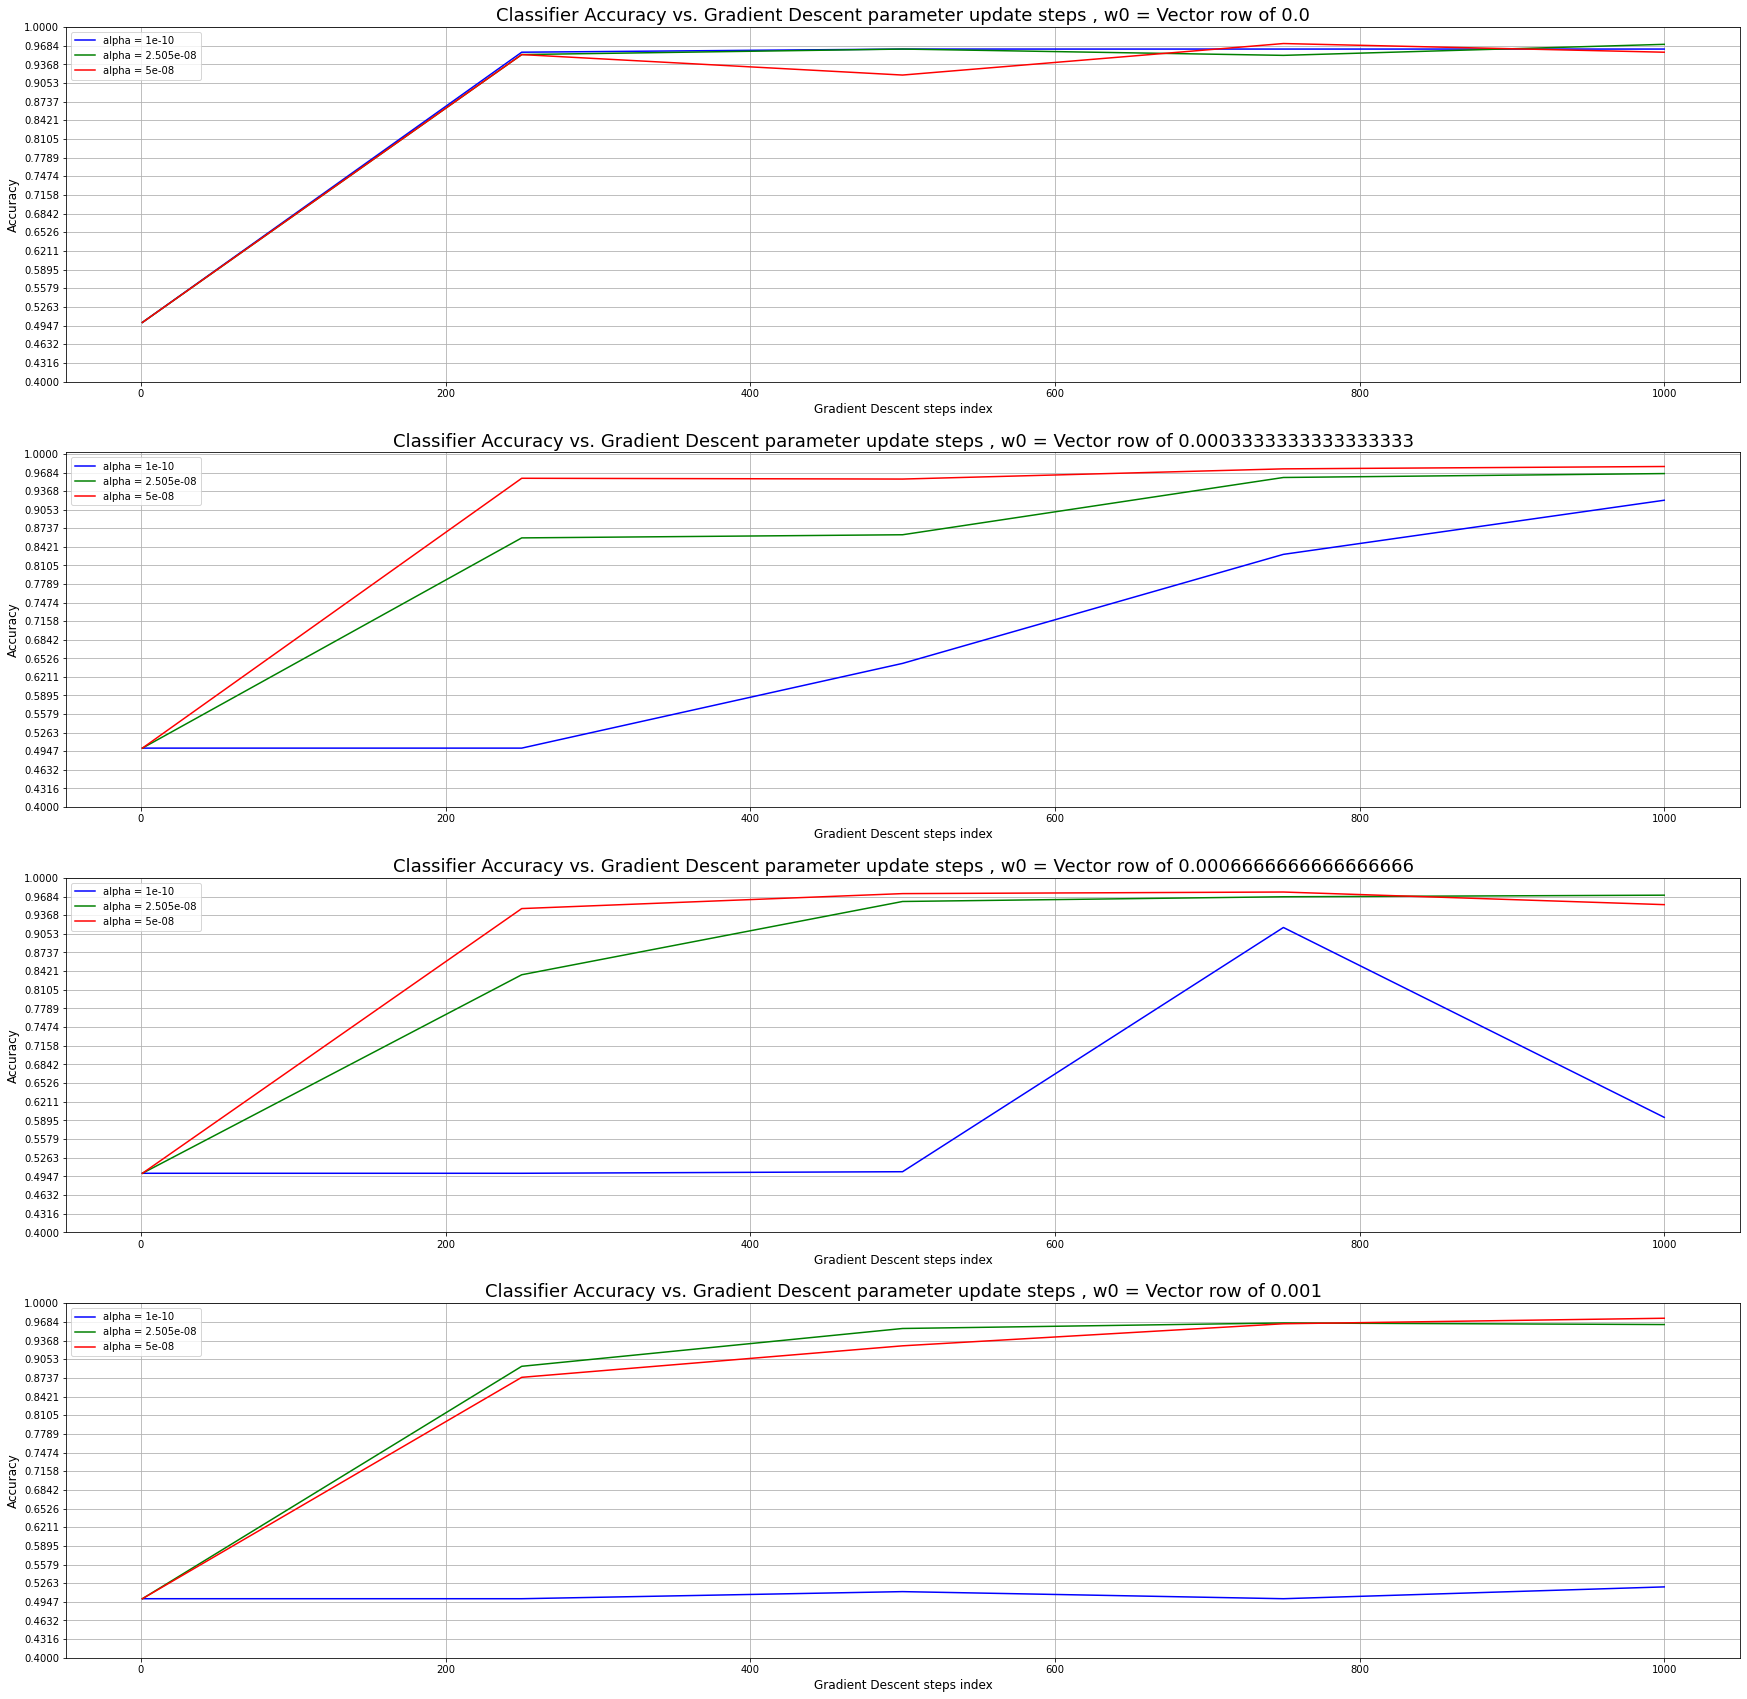

In [71]:
# Q4 - Choosing w0, alpha
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(30,30))
w0_zeros = np.zeros(Data.shape[1], dtype=int)
w0_steps = np.linspace(0,1e-03,4) # 4 coefficients

steps = np.linspace(1,1000,5).astype(int)
alpha = np.linspace(1e-10,5e-8,3)
arr_conf_matrix = np.ones(len(alpha)*len(steps), dtype=object)
arr_accuracy = np.zeros(len(alpha)*len(steps))
arr_color = ['b','g','r','c','m','y']

for w0 in range(len(w0_steps)):
    w0_zeros = w0_zeros + w0_steps[w0]
    print(w0)
    for a in range(len(alpha)):
        for s in range(len(steps)):
            w_gradient_descent = gradientDescent(w0_zeros,X_train,t_train,steps[s],alpha[a])
            arr_conf_matrix[len(alpha)*a + s] = confusionMatrix(X_train,t_train,w_gradient_descent,0.5)
            arr_accuracy[len(alpha)*a + s] = accuracy(arr_conf_matrix[len(alpha)*a + s])
        ax[w0].plot(steps,arr_accuracy[len(alpha)*a:len(alpha)*a+len(steps)],c=arr_color[a],label='alpha = ' + str(alpha[a]))
    ax[w0].set_title('Classifier Accuracy vs. Gradient Descent parameter update steps , w0 = Vector row of ' + str(w0_steps[w0]),fontsize=18)
    ax[w0].set_xlabel('Gradient Descent steps index',fontsize=12)
    ax[w0].set_ylabel('Accuracy',fontsize=12)
    ax[w0].set_yticks(np.linspace(0.4,1,20))
    ax[w0].grid()
    ax[w0].legend()

In [105]:
# Q4 - Computing the mse
w = np.zeros(Data.shape[1], dtype=int)
my_alpha = 1e-10
M = 250

w_optimal = gradientDescent(w,X_train,t_train,M,my_alpha)

mse_train = mse(X_train,w_optimal,t_train)
mse_test = mse(X_test,w_optimal,t_test)
print('mse_train = ' + str(mse_train))
print('mse_test = ' + str(mse_test))

mse_train = 0.04492841294627281
mse_test = 0.020303420267772886


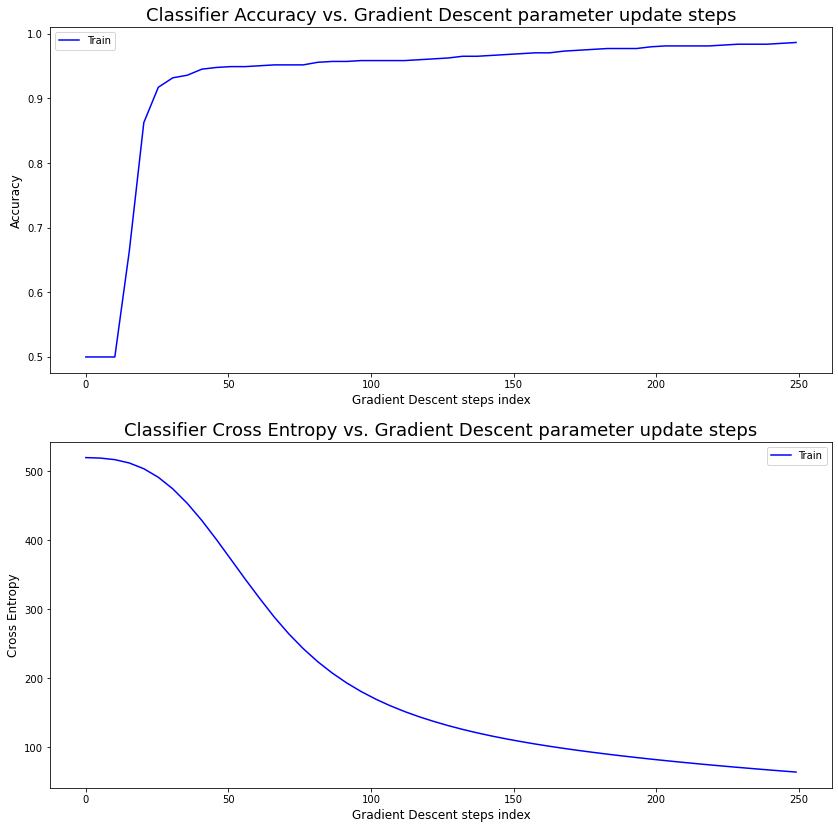

In [103]:
# Q5 - Train the Logistic Regressor
w = np.zeros(Data.shape[1], dtype=int)
arr_Ac_train = np.zeros(50) ## The confusion matrices of each m
arr_Lce_train = np.zeros(50) ## The confusion matrices of each m

for i in (np.linspace(0,M-1,50)).astype(int):
    w = gradientDescent(w,X_train,t_train,i,my_alpha)
    conf_matrix = confusionMatrix(X_train,t_train,w,0.5)
    arr_Ac_train[(i/5).astype(int)] = accuracy(conf_matrix)
    arr_Lce_train[(i/5).astype(int)] = crossEntropy(X_train,t_train,w)
    
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(14,14))

ax[0].plot(np.linspace(0,M-1,50),arr_Ac_train,c='b',label='Train')
ax[0].set_title('Classifier Accuracy vs. Gradient Descent parameter update steps',fontsize=18)
ax[0].set_ylabel('Accuracy',fontsize=12)
ax[0].set_xlabel('Gradient Descent steps index',fontsize=12)
ax[0].legend()

ax[1].plot(np.linspace(0,M-1,50),arr_Lce_train,c='b',label='Train')
ax[1].set_title('Classifier Cross Entropy vs. Gradient Descent parameter update steps',fontsize=18)
ax[1].set_ylabel('Cross Entropy',fontsize=12)
ax[1].set_xlabel('Gradient Descent steps index',fontsize=12)
ax[1].legend()

In [107]:
# Q5(b) - Train the Logistic Regressor
conf_matrix = confusionMatrix(X_test,t_test,w_optimal,0.5)
Ac_test = accuracy(conf_matrix)
print('Test Accuracy = ' + str(Ac_test))

Test Accuracy = 0.984


Train confusion matrix = 
[[373.  30.]
 [  2. 345.]]
Train confusion matrix = 
[[373.  30.]
 [  2. 345.]]


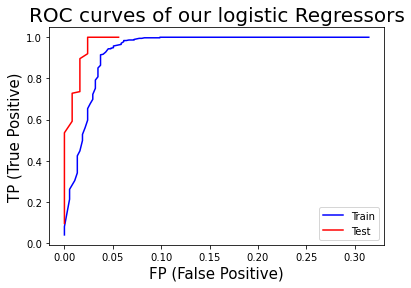

In [113]:
# Q5(c) - Confusion matrix and ROC curve of Train series
print('Train confusion matrix = \n' + str(confusionMatrix(X_train,t_train,w_optimal,0.5)))
print('Train confusion matrix = \n' + str(confusionMatrix(X_train,t_train,w_optimal,0.5)))

[TP_train,FP_train] = ROC(X_train,t_train,w_optimal)
[TP_test,FP_test] = ROC(X_test,t_test,w_optimal)

fig, ax = plt.subplots()
ax.plot(FP_train,TP_train,label='Train',c='b')
ax.plot(FP_test,TP_test,label='Test',c='r')
ax.set_title('ROC curves of our logistic Regressors',fontsize=20)
ax.set_xlabel('FP (False Positive)',fontsize=15)
ax.set_ylabel('TP (True Positive)',fontsize=15)
ax.legend()

In [124]:
# Q6 - Using Future Data
future_images = np.zeros((4), dtype=object)

# Read the images from FutureData Folder 
for i in range(4) :
    future_images[i] = cv2.imread('FutureData\\' + str(i + 500) +'.jpg',0)

# Q2.b - FFT 2 Dim for each image
for i in range(len(future_images)) :
    future_images[i] = np.fft.fft2(future_images[i])
    future_images[i] = np.fft.fftshift(future_images[i])

future_images = future_images + 1e-8

for i in range(len(future_images)) :
    future_images[i] = 20*np.log10(abs(future_images[i]))
    future_images[i] = azimuthalAverage(future_images[i])

Data = np.ones((4,723)) ## Represents the properties of each picture

for i in range(len(future_images)):
    Data[i,1:] = future_images[i][1:723]

In [130]:
for i in range(len(future_images)):
    p = likelihoodFunc(w_optimal.T@Data[i,:]) # y = 0
    if (p > 0.5): # y=1 - Fake
        print('Image number ' + str(i) + ' is Fake :(')
    else: # y=0 - Real
        print('Image number ' + str(i) + ' is Real :)')

Image number 0 is Real :)
Image number 1 is Real :)
Image number 2 is Fake :(
Image number 3 is Fake :(


In [134]:
# Writing the results to .csv file
f = open('FutureData\\FutureDataEstimatedLabels','w')
writer = csv.writer(f)
img1 = ['500.jpg','Real']
img2 = ['501.jpg','Real']
img3 = ['502.jpg','Fake']
img4 = ['503.jpg','Fake']
writer.writerow(img1)
writer.writerow(img2)
writer.writerow(img3)
writer.writerow(img4)
f.close()